# import

In [18]:
import sys 
sys.path.append('C:\\Users\\Nuo.Chen\\PycharmProjects\\Imbalance_price_forecast')
from utils.import_packages import *
# from data_gathering.prepare_data import *

from xgboost import XGBClassifier, XGBRegressor
from models.evaluation import *

In [19]:
train_df = pd.read_excel(data_folder_path + '/train.xlsx')
test_df = pd.read_excel(data_folder_path + '/test.xlsx')

## cross validation

In [3]:
def cross_validation(target, model, feat_params, df, isRegression, n_folds=5, print_temp_info=True):
    results = defaultdict(list)
    ts_split = TimeSeriesSplit(n_splits=n_folds)
    feat_cols = None

    for fold, (train_index, test_index) in enumerate(ts_split.split(df), 1):
        start_time = time.time()
        print('Fold:{}'.format(fold))
        cv_train = df.iloc[train_index, :]
        cv_test = df.iloc[test_index, :]

        if isRegression:
            train_x, train_y = regression_feat_pipeline(feat_params, cv_train)
            test_x, test_y = regression_feat_pipeline(feat_params, cv_test)
            feat_cols = train_x.columns
            cv_model = model()
            cv_model.fit(train_x, train_y[target])

            train_pred = [round(p, 2) for p in cv_model.predict(train_x)]
            test_pred = [round(p, 2) for p in cv_model.predict(test_x)]

            train_metrics = Evaluator(train_pred, train_y[target]).regression_metrics()
            test_metrics = Evaluator(test_pred, test_y[target]).regression_metrics()
            results['test_WMAPE'].append(test_metrics['WMAPE'])
            results['models'].append(cv_model)

            if print_temp_info:
                print('train:')
                print(train_metrics)
                print('test:')
                print(test_metrics)
                print('takes:{} min\n'.format(round((time.time() - start_time) / 60, 2)))
        else:
            train_x, train_y = classification_feat_pipeline(feat_params, cv_train)
            test_x, test_y = classification_feat_pipeline(feat_params, cv_test)
            feat_cols = train_x.columns
            
            cv_model = model()
            cv_model.fit(train_x, train_y[target])
#             train_pred = cv_model.predict_proba(train_x)[:, 1]
#             test_pred = cv_model.predict_proba(test_x)[:, 1]
            train_pred = cv_model.predict(train_x)
            test_pred = cv_model.predict(test_x)

            train_metrics = Evaluator(train_pred, train_y[target]).classification_metrics()
            test_metrics = Evaluator(test_pred, test_y[target]).classification_metrics()
            results['auc'].append(test_metrics['AUC'])
            results['models'].append(cv_model)

            if print_temp_info:
                print('train:')
                print(train_metrics)
                print('test:')
                print(test_metrics)
                print('takes:{} min\n'.format(round((time.time() - start_time) / 60, 2)))

    return results, feat_cols


# train regression

train: 2016-01-01 - 2016-12-11

test: 2017-12-27 - 2018-6-1

train/test = 7:3

## feat pipeline

In [16]:
def regression_feat_pipeline(lag_dict, df):
    df = make_date_feature(df)
    # hot-encoding weekday and pte    
    dummy_date = pd.get_dummies(df['weekday'], prefix='weekday')
    dummy_PTE = pd.get_dummies(df['PTE'], prefix = 'PTE')
    df = pd.concat([df, dummy_date, dummy_PTE], axis = 1)
    df.drop(['weekday'], axis=1)

    # lag feat
    for lag_column, lag_value in lag_dict.items():
        lag_feat = make_lag_feat(lag_column, lag_value, df)
        df = pd.concat([df, lag_feat], axis=1)
    
   # standardize
    clasy_cols = ['DA>FEED', 'DA>TAKE', 'Date', 'DateTime','day', 'month','PTE','weekday',
                        'week', 'sin_weekday', 'sin_month', 'sin_day', 'sin_PTE',
                        'take_from_system_price', 'feed_into_system_price']
    clasy_cols.extend(dummy_date.columns)
    clasy_cols.extend(dummy_PTE.columns)

    df= standardize_feat(df, clasy_cols)
    
    # select x,y
    y = df[['DA>FEED', 'DA>TAKE', 'take_from_system_price', 'feed_into_system_price']]    
    X = df.drop(['DA>FEED', 'DA>TAKE', 'take_from_system_price', 'feed_into_system_price',\
                 'DA-price', 'system_purchase_vol', 'system_sell_vol', 'system_absolute_vol',\
                 'DateTime', 'week', 'Date', 'PTE','weekday'], \
                axis=1)
    return X, y                                                                        

In [17]:
# def regression_feat_pipeline(lag_dict, df):
#     df = make_date_feature(df)
#     # hot-encoding weekday and pte
#     df = dummy_feat(df)
    
#     # lag feat
#     for lag_column, lag_value in lag_dict.items():
#         lag_feat = make_lag_feat(lag_column, lag_value, df)
#         df = pd.concat([df, lag_feat], axis=1)

#     # standardize
#     df = standardize_feat(df)
    
#     # select x,y
#     y = df[['DA>FEED', 'DA>TAKE', 'take_from_system_price', 'feed_into_system_price']]
#     X = df.drop(['DA>FEED', 'DA>TAKE', 'take_from_system_price', 'feed_into_system_price', \
#                  'DA-price', 'system_purchase_vol', 'system_sell_vol', 'system_absolute_vol', \
#                  'DateTime', 'week', 'Date', 'PTE'], \
#                 axis=1)

#     return X, y

In [18]:
lag_values = {'yesterday': np.arange(96,96*2),\
             'two_days': np.arange(96, 96*3),\
             'same_time_before': [96, 96*2, 96*3],\
             'around_time_before':[96, 97, 95*2, 96*2, 97*2]}
lag_dict = {'take_from_system_price':lag_values['yesterday'],\
           'feed_into_system_price':lag_values['yesterday'],\
           'DA-price':lag_values['around_time_before'],\
           'system_purchase_vol':lag_values['around_time_before'],\
           'system_sell_vol':lag_values['around_time_before'],\
           'system_absolute_vol':lag_values['around_time_before'],\
           'wind_value':lag_values['around_time_before']}

## train

In [24]:
# X, Y = regression_feat_pipeline(lag_dict, train_df)

In [23]:
out1,feat_cols = cross_validation('take_from_system_price',XGBRegressor,\
                                  lag_dict,train_df, isRegression = True) 

Fold:1
train:
{'MPE': 15.8516, 'MAPE': 105.9107, 'WMAPE': 0.0149}
test:
{'MPE': -78.9424, 'MAPE': 225.4703, 'WMAPE': 0.0212}
takes:0.37 min

Fold:2
train:
{'MPE': -14.8722, 'MAPE': 140.6368, 'WMAPE': 0.0079}
test:
{'MPE': -inf, 'MAPE': inf, 'WMAPE': 0.0122}
takes:0.47 min

Fold:3
train:
{'MPE': -inf, 'MAPE': inf, 'WMAPE': 0.0046}
test:
{'MPE': 24.7906, 'MAPE': 90.8667, 'WMAPE': 0.0142}
takes:0.55 min

Fold:4
train:
{'MPE': -inf, 'MAPE': inf, 'WMAPE': 0.0035}
test:
{'MPE': -inf, 'MAPE': inf, 'WMAPE': 0.0131}
takes:0.66 min

Fold:5
train:
{'MPE': -inf, 'MAPE': inf, 'WMAPE': 0.0028}
test:
{'MPE': 4.4948, 'MAPE': 73.0832, 'WMAPE': 0.0102}
takes:0.74 min



## feat importance

In [25]:
model_error = out1['test_WMAPE']
best_model = out1['models'][model_error.index(min(model_error))]

plot_feature_importance(best_model, feat_cols)[-20:]

,importances,features
309,0.013514,DA-price_96
105,0.013514,PTE_85
12,0.013514,sin_PTE
9,0.015015,cos_month
320,0.015015,system_sell_vol_97
323,0.015015,system_sell_vol_194
321,0.016517,system_sell_vol_190
5,0.016517,wind_minvalue
10,0.018018,sin_day
4,0.018018,wind_maxvalue


## test

In [26]:
test_x, test_y = regression_feat_pipeline(lag_dict, test_df)
test_true = test_y['take_from_system_price']
test_pred = best_model.predict(test_x)
test_pred = [round(p,2) for p in test_pred]

In [27]:
metrics = Evaluator(test_pred, test_true).regression_metrics()
metrics

{'MPE': 68.457, 'MAPE': 118.587, 'WMAPE': 0.0058}

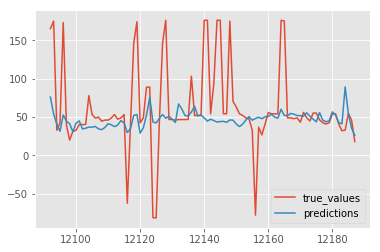

In [28]:
_ = plot_predictions( test_pred[-96:], test_true[-96:] )

In [29]:
save_result_to_file(data_folder_path+'/results/regression_wmape/', metrics['WMAPE'], lag_dict)

# DA > TAKE

## feat pipeline

In [4]:
lag_values2 = {'yesterday': np.arange(96,96*2),\
             'two_days': np.arange(96, 96*3),\
             'same_time_before': [96, 96*2, 96*3],\
             'around_time_before':[96, 97, 95*2, 96*2, 97*2]}
lag_dict2 = {'take_from_system_price':lag_values2['yesterday'],\
           'feed_into_system_price':lag_values2['yesterday'],\
           'DA-price':lag_values2['around_time_before'],\
           'system_purchase_vol':lag_values2['around_time_before'],\
           'system_sell_vol':lag_values2['around_time_before'],\
           'system_absolute_vol':lag_values2['around_time_before'],\
           'wind_value':lag_values2['around_time_before']}

In [5]:
def classification_feat_pipeline(lag_dict, df):
    df = make_date_feature(df)
    # hot-encoding weekday and pte    
    dummy_date = pd.get_dummies(df['weekday'], prefix='weekday')
    dummy_PTE = pd.get_dummies(df['PTE'], prefix = 'PTE')
    df = pd.concat([df, dummy_date, dummy_PTE], axis = 1)
    df.drop(['weekday'], axis=1)

    # lag feat
    for lag_column, lag_value in lag_dict.items():
        lag_feat = make_lag_feat(lag_column, lag_value, df)
        df = pd.concat([df, lag_feat], axis=1)
    
   # standardize
    clasy_cols = ['DA>FEED', 'DA>TAKE', 'Date', 'DateTime','day', 'month','PTE','weekday',
                        'week', 'sin_weekday', 'sin_month', 'sin_day', 'sin_PTE',
                        'take_from_system_price', 'feed_into_system_price']
    clasy_cols.extend(dummy_date.columns)
    clasy_cols.extend(dummy_PTE.columns)

    df= standardize_feat(df, clasy_cols)
    
    # select x,y
    y = df[['DA>FEED', 'DA>TAKE', 'take_from_system_price', 'feed_into_system_price']]    
    X = df.drop(['DA>FEED', 'DA>TAKE', 'take_from_system_price', 'feed_into_system_price',\
                 'DA-price', 'system_purchase_vol', 'system_sell_vol', 'system_absolute_vol',\
                 'DateTime', 'week', 'Date', 'PTE','weekday'], \
                axis=1)
    return X, y

## train

In [6]:
out2,feat_cols2 = cross_validation('DA>TAKE',XGBClassifier,\
                                  lag_dict2,train_df, isRegression = False,\
                                   n_folds = 5) 

Fold:1
train:
{'AUC': '0.9284', 'Accuracy': 75.4994}
test:
{'AUC': '0.6097', 'Accuracy': 72.1294}
takes:0.43 min

Fold:2
train:
{'AUC': '0.8524', 'Accuracy': 75.2692}
test:
{'AUC': '0.6027', 'Accuracy': 71.2151}
takes:0.52 min

Fold:3
train:
{'AUC': '0.8106', 'Accuracy': 73.1946}
test:
{'AUC': '0.6237', 'Accuracy': 69.2286}
takes:0.62 min

Fold:4
train:
{'AUC': '0.7863', 'Accuracy': 71.6706}
test:
{'AUC': '0.6572', 'Accuracy': 67.6464}
takes:0.75 min

Fold:5
train:
{'AUC': '0.7689', 'Accuracy': 70.41}
test:
{'AUC': '0.6747', 'Accuracy': 64.1109}
takes:0.84 min



## feat importance

In [7]:
model_auc = out2['auc']
best_model2 = out2['models'][model_auc.index(max(model_auc))]

plot_feature_importance(best_model2, feat_cols2)[-10:]

,importances,features
13,0.018625,cos_PTE
5,0.018625,wind_minvalue
113,0.018625,PTE_93
10,0.020057,sin_day
322,0.025788,system_sell_vol_192
8,0.027221,sin_month
11,0.027221,cos_day
309,0.032951,DA-price_96
117,0.034384,take_from_system_price_96
12,0.041547,sin_PTE


## test

In [17]:
test_x, test_y = classification_feat_pipeline(lag_dict2, test_df)
test_y = test_y['DA>TAKE']
test_proba = best_model2.predict_proba(test_x)[:,1]
test_pred = best_model2.predict(test_x)

metrics2 = Evaluator(test_pred, test_y).classification_metrics()
metrics2

{'AUC': '0.5062', 'Accuracy': 78.2641}

In [16]:
len(test_y[test_y == 1])/len(test_y)

0.7813906953476738

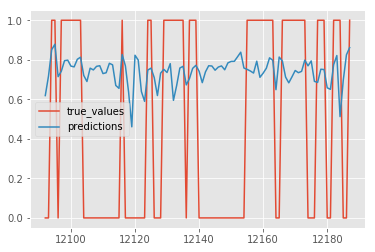

In [35]:
_ = plot_predictions( test_proba[-96:], test_y[-96:] )

In [39]:
save_result_to_file(data_folder_path+'/results/classification_acc/', metrics2['Accuracy'], lag_dict)